In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import h5py
import pqcd

from universality.gaussianprocess.utils import integrate_phi
from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre,
    )

### Inspect exisiting tabulated EOSs

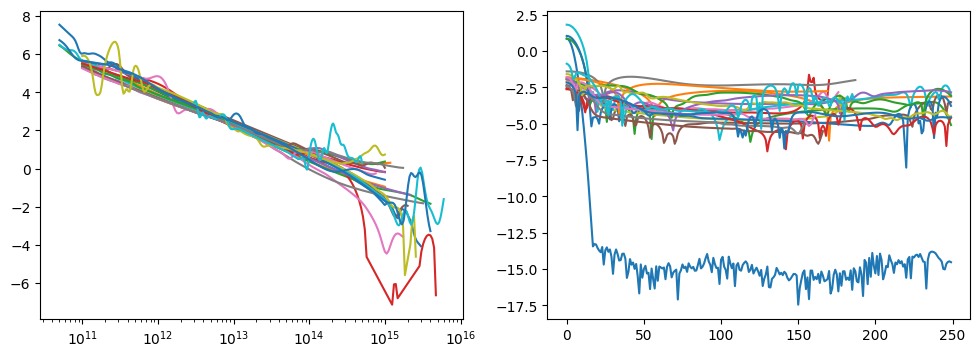

In [2]:
hdf5_paths = {
    'had': ['bsk', 'bsr', 'dd', 'eng', 'gm', 'kde', 'mpa', 'nl', 'r', 'sk', 'sly', 'tm'],
    'hyp': ['bsr', 'dd', 'gm', 'h', 'nl', 'tm'],
    'qrk': ['alf', 'ddq', 'hqc']
}

fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].set_xscale('log')

min_cov = 10

for variety in ['had', 'hyp', 'qrk']:

    for label in hdf5_paths[variety]:

        if variety == 'had':
            file_path = f'../data/eos-draws-default/make-agnostic-processes/{variety}agn/{label}/gpr_gpr_{variety}ronic-{label}.hdf5'
        elif variety == 'hyp':
            file_path = f'../data/eos-draws-default/make-agnostic-processes/{variety}agn/{label}/gpr_gpr_{variety}eronic-{label}.hdf5'
        elif variety == 'qrk':
            file_path = f'../data/eos-draws-default/make-agnostic-processes/{variety}agn/{label}/gpr_gpr_quark-{label}.hdf5'
        
        with h5py.File(file_path, 'r') as f:
            cov = np.array(f['0']['cov'])
            mean = np.array(f['0']['mean'])

        log_pressure = np.array([entry[0] for entry in mean])
        phi = np.array([entry[1] for entry in mean])

        axs[0].plot(np.exp(log_pressure), phi)
        axs[1].plot(np.log10(abs(cov[:,0])))

        if cov[0,0] < min_cov:
            min_cov_variety = variety
            min_cov_label = label
            min_cov = cov[0,0]

In [3]:
min_cov_variety, min_cov_label, min_cov

('had', 'eng', 0.002362851813474719)

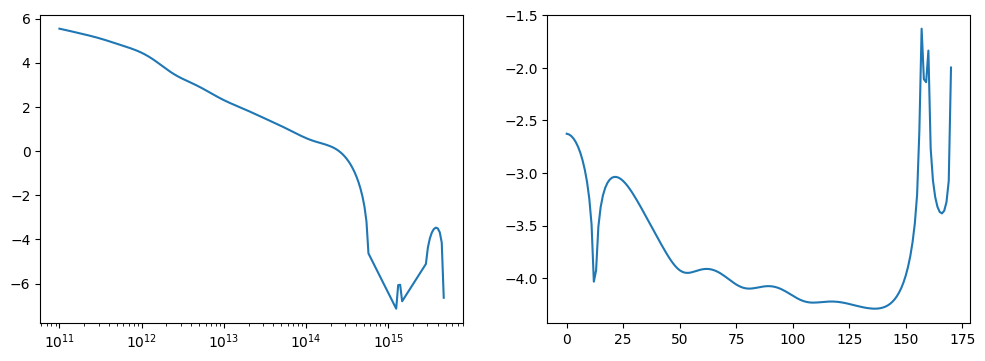

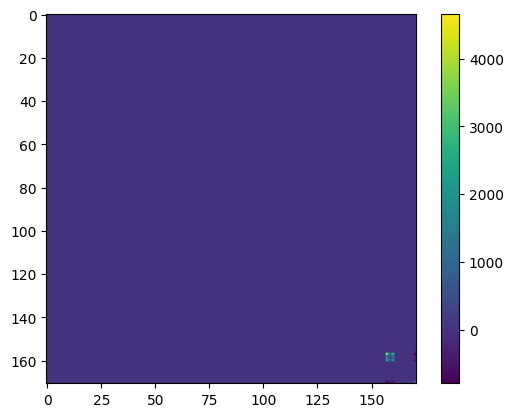

In [4]:
file_path = '../data/eos-draws-default/make-agnostic-processes/hadagn/eng/gpr_gpr_hadronic-eng.hdf5'

with h5py.File(file_path, 'r') as f:
    cov = np.array(f['0']['cov'])
    mean = np.array(f['0']['mean'])

log_pressure = np.array([entry[0] for entry in mean])
phi = np.array([entry[1] for entry in mean])

fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].set_xscale('log')

axs[0].plot(np.exp(log_pressure), phi)
axs[1].plot(np.log10(abs(cov[:,0])))

fig, ax = plt.subplots()

ax.imshow(cov, cmap='viridis')
fig.colorbar(ax.imshow(cov, cmap='viridis'));

Lets try modify an existing tabulated EOS...

In [5]:
# Load the means we want to use as the new tabulated EOSs. This could be from a 
# previous GP draw, or a random walk?

gp_mean_dict = {}

for variety in ['had', 'hyp', 'qrk']:

    hdf5_path = f'../data/eos-draws-modified/gp1/{variety}agn/gpr_gpr_{variety}agn.hdf5'

    gp_mean_dict[variety] = {}

    with h5py.File(hdf5_path, 'r') as f:
        for key in f.keys():

            cov = np.array(f[key]['cov'])
            mean = np.array(f[key]['mean'])

            log_pressure = np.array([entry[0] for entry in mean])
            phi = np.array([entry[1] for entry in mean])

            gp_mean_dict[variety][key] = (log_pressure, phi)

consistent_phi_arrays = []
consistent_logp_arrays = []

N_samp = 1000

pqcd_region_dict = pqcd.get_pqcd_region()

for variety in ['had', 'hyp', 'qrk']:
    for n in range(N_samp):

        eos = pd.read_csv(
            f'../data/eos-draws-modified/gp1/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv'
        )
        
        if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):

            gp = pd.read_csv(
                f'../data/eos-draws-modified/gp1/{variety}agn/DRAWmod1000-{int(n/1000):06}/draw-gpr_{variety}agn-{n:06}.csv', 
                comment='#'
            )
        
            consistent_phi_arrays.append(gp['phi'].values)
            consistent_logp_arrays.append(gp['log(pressurec2)'].values)

In [6]:
len(consistent_logp_arrays)

1661

In [7]:
rng = np.random.default_rng()

In [8]:
new_mean_phi_array = rng.choice(np.array(consistent_phi_arrays), size=1000, replace=False)

In [9]:
# The log(p) arrays are all the same
new_mean_logp = consistent_logp_arrays[0]

# Select our new mean
# new_mean_phi_array = np.array(consistent_phi_arrays)
# new_mean_phi = phi_array[0]

In [10]:
len(new_mean_logp), len(new_mean_phi_array[0])

(500, 500)

In [11]:
# We'll need a new covariance... use zeros?
new_cov = np.zeros((len(new_mean_logp), len(new_mean_logp)))

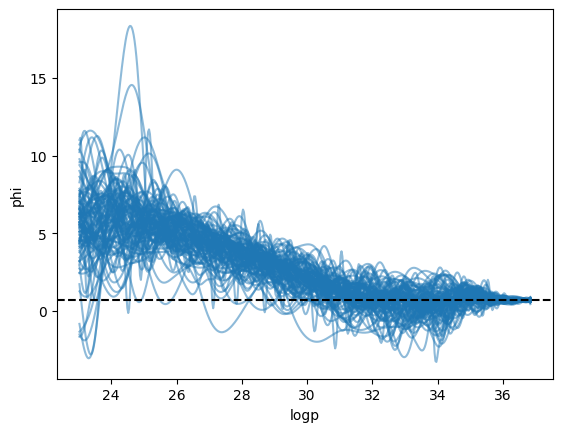

In [12]:
fig, ax = plt.subplots()

for phi in new_mean_phi_array[:100]:
    ax.plot(new_mean_logp, phi, c='C0', alpha=0.5)

ax.axhline(np.log(2), c='k', ls='--', zorder=10)

ax.set_xlabel('logp')
ax.set_ylabel('phi');

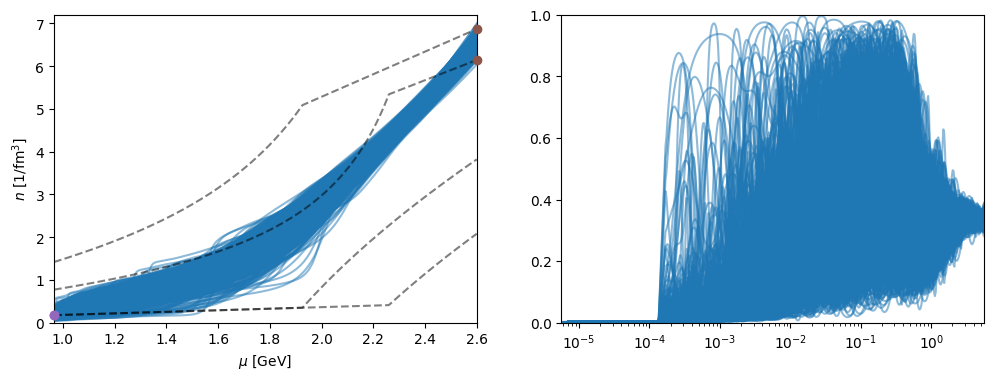

In [13]:
min_pressure = to_GeV_per_cubic_femtometre(1e10)
max_pressure = to_GeV_per_cubic_femtometre(1e16)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[1].set_xscale('log')

CET_values = {
    'soft': [0.966, 0.176, 2.163/1000],
    'stiff': [0.978, 0.176, 3.542/1000]
}

muL, nL, pL = CET_values['soft']
muH = 2.6

mu_array = np.linspace(muL, muH, 1000)

for X in [0.5, 2]:

    pQCDX = pqcd.pQCD(X)
    nH, pH = pQCDX.nH(muH), pQCDX.pH(muH)
    epsilonH = pqcd.epsilon_func(muH, nH, pH)

    constraints = pqcd.constraints(muL, nL, pL, muH, nH, pH)

    axs[0].plot(constraints.muL, constraints.nL, 'o', c='C4', zorder=11, clip_on=False)
    axs[0].plot(constraints.muH, constraints.nH, 'o', c='C5', zorder=11, clip_on=False)

    ylim = [0, axs[0].get_ylim()[1]]

    axs[0].plot(mu_array, constraints.nmin(mu_array), c='k', ls='--', alpha=0.5, zorder=10)
    axs[0].plot(mu_array, constraints.nmax(mu_array), c='k', ls='--', alpha=0.5, zorder=10)

for phi in new_mean_phi_array:

    eos, cols = integrate_phi(
        np.exp(new_mean_logp),
        phi,
        reference_pressurec2=3e11,
        sigma_logpressurec2=0,
        stitch_below_reference_pressure=True,
        include_baryon_density=True,
        include_cs2c2=True,
        include_baryon_chemical_potential=False,
        verbose=False
    )

    pressure = to_GeV_per_cubic_femtometre(eos[:, cols.index('pressurec2')])
    energy_density = to_GeV_per_cubic_femtometre(eos[:, cols.index('energy_densityc2')])
    number_density = to_nucleons_per_cubic_femtometre(eos[:, cols.index('baryon_density')])

    chemical_potential = (energy_density+pressure)/number_density
    speed_of_sound_squared = np.gradient(pressure, energy_density)

    axs[0].plot(chemical_potential, number_density, c='C0', alpha=0.5)

    axs[1].plot(pressure, speed_of_sound_squared, c='C0', alpha=0.5)

axs[0].set_xlim(constraints.muL, constraints.muH)
axs[0].set_ylim(ylim)

axs[1].set_xlim(min_pressure, max_pressure)
axs[1].set_ylim(0, 1)

axs[0].set_xlabel(r'$\mu$ [GeV]')
axs[0].set_ylabel(r'$n$ [1/fm$^3$]');

In [14]:
# np.savetxt(
#     '../data/eos-draws-modified/gp2/means.dat', 
#     np.vstack([new_mean_logp, new_mean_phi_array]).T
# )

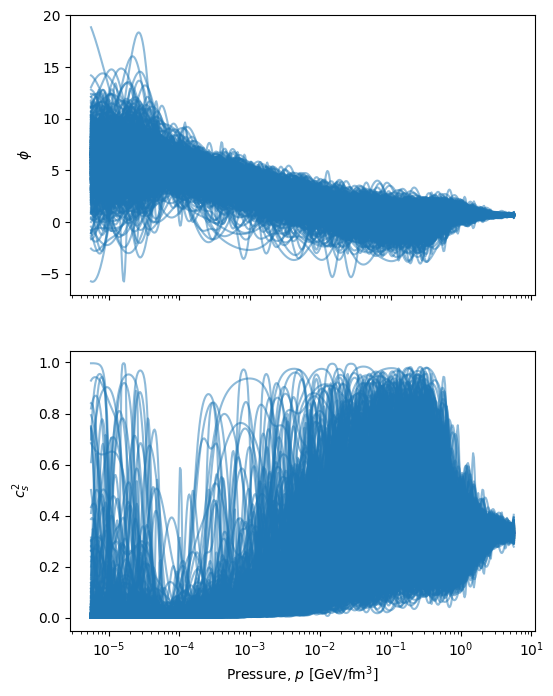

In [15]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6,8))
axs[0].set_xscale('log')

for phi in new_mean_phi_array:
        
        axs[0].plot(
            to_GeV_per_cubic_femtometre(np.exp(new_mean_logp)), 
            phi, 
            c='C0',
            alpha=0.5
        )
        axs[1].plot(
            to_GeV_per_cubic_femtometre(np.exp(new_mean_logp)), 
            1/(1+np.exp(phi)), 
            c='C0',
            alpha=0.5
        )

axs[1].set_xlabel(r'Pressure, $p$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'$\phi$')
axs[1].set_ylabel(r'$c_s^2$');

In [16]:
len(new_mean_phi_array[::10])

100

In [17]:
labels = [
    'a',
    'b',
    'c',
    'd',
    'e',
    'f',
    'g',
    'h',
    'i',
    'j',
    'k',
    'l',
]

In [18]:
# hdf5_source = '../make-agnostic-processes/hadagn/bsk/gpr_gpr_hadronic-bsk.hdf5'

# for i, new_mean_phi in enumerate(new_mean_phi_array[::10][:12]):

#     new_mean = np.empty(
#         len(new_mean_logp), 
#         dtype=[('log(pressurec2)', 'float'), ('phi', 'float')]
#         )
#     new_mean['log(pressurec2)'][:] = new_mean_logp
#     new_mean['phi'][:] = new_mean_phi

#     destination_dir = f'../data/eos-draws-default/make-agnostic-processes-tests/cus{labels[i]}agn/{labels[i]}'
#     os.makedirs(destination_dir, exist_ok=True)
#     hdf5_destination = f'{destination_dir}/gpr_gpr_custom-{labels[i]}.hdf5'

#     with h5py.File(hdf5_source, 'r') as f_src:
#         with h5py.File(hdf5_destination, 'w') as f_dest:

#             # Copy all the groups and datasets
#             f_src.copy('0', f_dest)

#             # Delete the original dataset
#             del f_dest['0']['mean']
#             del f_dest['0']['cov']

#             # Create a new dataset
#             f_dest['0'].create_dataset('mean', data=new_mean)
#             f_dest['0'].create_dataset('cov', data=new_cov)

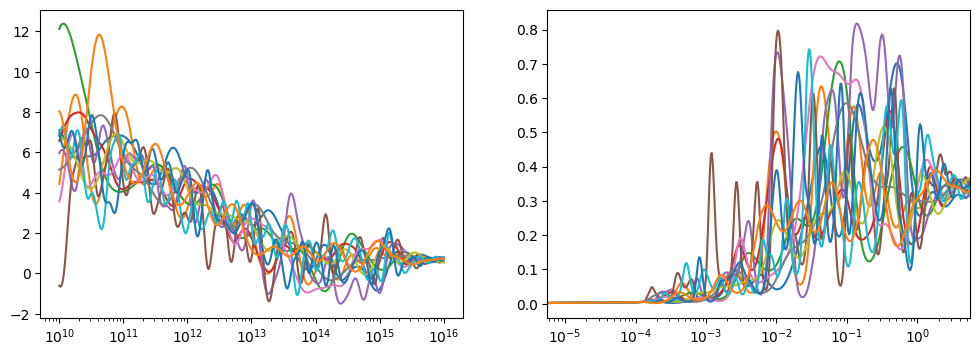

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].set_xscale('log')
axs[1].set_xscale('log')

min_pressure = to_GeV_per_cubic_femtometre(1e10)
max_pressure = to_GeV_per_cubic_femtometre(1e16)

variety = 'cus'

for label in labels:

    file_path = (
        '../data/eos-draws-default/make-agnostic-processes-tests/'
        f'{variety}{label}agn/{label}/gpr_gpr_custom-{label}.hdf5'
    )
    
    with h5py.File(file_path, 'r') as f:
        cov = np.array(f['0']['cov'])
        mean = np.array(f['0']['mean'])

    log_pressure = np.array([entry[0] for entry in mean])
    phi = np.array([entry[1] for entry in mean])

    eos, cols = integrate_phi(
        np.exp(log_pressure),
        phi,
        reference_pressurec2=3e11,
        sigma_logpressurec2=0,
        stitch_below_reference_pressure=True,
        include_baryon_density=True,
        include_cs2c2=True,
        include_baryon_chemical_potential=False,
        verbose=False
    )

    pressure = to_GeV_per_cubic_femtometre(eos[:, cols.index('pressurec2')])
    energy_density = to_GeV_per_cubic_femtometre(eos[:, cols.index('energy_densityc2')])
    number_density = to_nucleons_per_cubic_femtometre(eos[:, cols.index('baryon_density')])

    chemical_potential = (energy_density+pressure)/number_density
    speed_of_sound_squared = np.gradient(pressure, energy_density)

    axs[0].plot(np.exp(log_pressure), phi)
    axs[1].plot(pressure, speed_of_sound_squared)

axs[1].set_xlim(min_pressure, max_pressure);